# 9. Spatial Joins

In this notebook we'll continue the analysis we started with the previous notebook. We'll be able to answer the question *How many Bart stations are within walking distance of each parcel?*

We'll load all of our packages and the data we need.

In [1]:
import math
import numpy as np
import pandas as pd
import collections
import requests 
from urllib.request import urlopen, Request

import json # for working with JSON data
import geojson # ditto for GeoJSON data - an extension of JSON with support for geographic data
import geopandas as gpd
# import mapclassify # to classify data values

import matplotlib # base python plotting library
%matplotlib inline  
import matplotlib.pyplot as plt # more plotting stuff

### Step 5. Spatially join the Permit buffers and BART data

Great, now that we have our data in the right CRS with our new BART count variable, we're going to go ahead and identify the school locations within waking distance of a BART station.

To do that, we're going to do a **spatial join** using the geopandas **sjoin** function. 

In [55]:
help(gpd.sjoin)

Help on function sjoin in module geopandas.tools.sjoin:

sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    Spatial join of two GeoDataFrames.
    
    Parameters
    ----------
    left_df, right_df : GeoDataFrames
    how : string, default 'inner'
        The type of join:
    
        * 'left': use keys from left_df; retain only left_df geometry column
        * 'right': use keys from right_df; retain only right_df geometry column
        * 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column
    op : string, default 'intersects'
        Binary predicate, one of {'intersects', 'contains', 'within'}.
        See http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates.
    lsuffix : string, default 'left'
        Suffix to apply to overlapping column names (left GeoDataFrame).
    rsuffix : string, default 'right'
        Suffix to apply to overlapping column names (right GeoDataFrame).



Before proceeding, consider this:

- What geodataframe should be listed first in the spatial join as the `left_df`? Why does this matter?
- Do we want to do a default inner join or a left join?
- What will the output geometry type be? What do we want it to be?



<img align="left" width=500 src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Cat_on_laptop_-_Just_Browsing.jpg"></img>


OK, spatial join time!

In [2]:
# Bring in our school and bart data 
bart_buf_gdf = gpd.read_file("../outdata/bart_buffers.json")
schools_3310 = gpd.read_file("../outdata/berkeley_schools.json")

In [3]:
# Join the bart data to the permit data to identify permit locations near bart
schools_near_bart_gdf = gpd.sjoin(schools_3310,bart_buf_gdf)
schools_near_bart_gdf.head()

,X,Y,Site,Address,City,State,Type,API,Org,geometry,index_right,STATION,bart_count
6,-122.273754,37.852278,Malcolm X Elementary,1731 Prince St,Berkeley,CA,ES,834,Public,POINT (-199778.363 -15845.380),2,ASHBY,1
10,-122.272412,37.867003,Washington Elementary,2300 M L King Jr. Way,Berkeley,CA,ES,811,Public,POINT (-199621.189 -14211.715),1,DOWNTOWN BERKELEY,1
14,-122.272486,37.868367,Berkeley High,2223 Martin Luther King Jr. Way,Berkeley,CA,HS,0,Public,POINT (-199624.108 -14060.015),1,DOWNTOWN BERKELEY,1
23,-122.263331,37.868052,Global Montessori International School,2314 Bancroft Way,Berkeley,CA,K-6,0,private,POINT (-198820.877 -14114.234),1,DOWNTOWN BERKELEY,1
30,-122.280841,37.870741,West-Wind Academy,1551 University Avenue,Berkeley,CA,1 to 12,0,private,POINT (-200351.528 -13778.534),0,NORTH BERKELEY,1


<img align="left" width=500 src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Sad_Lucy.jpg/640px-Sad_Lucy.jpg"></img>

Before diving too deep into our results. We can start by double checking the shape of our input and output geodataframes to make sure they seem reasonable.

In [6]:
print("Number of  schools",len(schools_3310))
print("Number of BART stations:",len(bart_buf_gdf))
print("Number of schools in BART bufs",len(schools_near_bart_gdf))

Number of  schools 32
Number of BART stations: 44
Number of schools in BART bufs 5



### Step 6. Count the number of Bart Stations within walking Distance of Permit Locations

Now that we have done our spatial join, we can sum the count of BART stations within walking distance of permit locations. We will dissolve duplicate geometries that share the same `jurisdiction_id`, assuming this to be a unique ID for the permit applications.

In [8]:
# Need to double check that the 'APN2' is the unique identifier
schools_bart_counts_gdf = schools_near_bart_gdf[['Site','geometry','bart_count']].dissolve(by='Site', aggfunc="sum", as_index=False)
schools_bart_counts_gdf

,Site,geometry,bart_count
0,Berkeley High,POINT (-199624.108 -14060.015),1
1,Global Montessori International School,POINT (-198820.877 -14114.234),1
2,Malcolm X Elementary,POINT (-199778.363 -15845.380),1
3,Washington Elementary,POINT (-199621.189 -14211.715),1
4,West-Wind Academy,POINT (-200351.528 -13778.534),1


We can combine this output with our sjoin input schools geodataframe (`schools_3310`) to enhance the school information.

In [10]:
schools_gdf_enhanced = schools_3310.merge(schools_bart_counts_gdf[['Site','bart_count']], on="Site", how="left")


In [11]:
# Take a look
schools_gdf_enhanced.sort_values(by="bart_count", ascending=False).head()

,X,Y,Site,Address,City,State,Type,API,Org,geometry,bart_count
6,-122.273754,37.852278,Malcolm X Elementary,1731 Prince St,Berkeley,CA,ES,834,Public,POINT (-199778.363 -15845.380),1.0
10,-122.272412,37.867003,Washington Elementary,2300 M L King Jr. Way,Berkeley,CA,ES,811,Public,POINT (-199621.189 -14211.715),1.0
14,-122.272486,37.868367,Berkeley High,2223 Martin Luther King Jr. Way,Berkeley,CA,HS,0,Public,POINT (-199624.108 -14060.015),1.0
23,-122.263331,37.868052,Global Montessori International School,2314 Bancroft Way,Berkeley,CA,K-6,0,private,POINT (-198820.877 -14114.234),1.0
30,-122.280841,37.870741,West-Wind Academy,1551 University Avenue,Berkeley,CA,1 to 12,0,private,POINT (-200351.528 -13778.534),1.0


In [13]:
schools_gdf_enhanced.shape

(32, 11)

Now let's use `value_counts` to check the distribution of values in the `bart_count` column.

In [15]:
schools_gdf_enhanced.bart_count.value_counts(dropna=False)

NaN    27
1.0     5
Name: bart_count, dtype: int64

You can see above that after the merge the `bart_count` column is NaN (not a number/null) for school locations that were not within walking distance to BART.

We can use the `fillna()` method to set those values to zero.

In [16]:
schools_gdf_enhanced.bart_count.fillna(0, inplace=True)

# And check the counts again
schools_gdf_enhanced.bart_count.value_counts(dropna=False)

0.0    27
1.0     5
Name: bart_count, dtype: int64

Phew! now let's map our output. The ultimate sanity check.

In [20]:
# Bring in our Berkeley outline
berkeley_outline = gpd.read_file("zip://../qgis_workshop_data/BerkeleyCityLimits.zip")
berkeley_3310 = berkeley_outline.to_crs('epsg:3310')

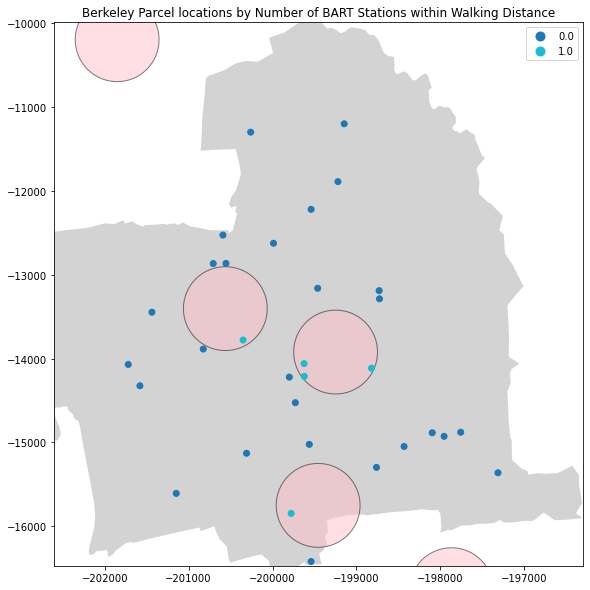

In [21]:
# Map it
fig, ax = plt.subplots(figsize = (10,10)) 

# Berkeley outline 
berkeley_3310.plot(color = 'lightgrey', ax=ax)

# Display the buffer output in PINK
bart_buf_gdf.plot(ax=ax, edgecolor="black",color="pink", alpha=0.5)

# Overlay the bart points in RED
schools_gdf_enhanced.sort_values(by="bart_count").plot(ax=ax, column='bart_count', categorical=True, legend=True)

# Set x and y limits to zoom into Berkeley
ax.set_xlim([-202600,-196300])
ax.set_ylim([-16470,-9990])

ax.set_title('Berkeley Parcel locations by Number of BART Stations within Walking Distance')
plt.show()

---
<a id="section5"></a>
## Challenge

####  Exercise

Do another buffer analysis, this time use any of the following data that you find in the folders:

>`notebook_data/transportation`
> - `sfmta_stations.zip` - SF MTA station locations
> - `regional_bike_facilities.zip` - Off-street shared use path, bike lanes, and on-street bike routes
> - `baywheels_stations.zip` - Baywheel station locations

> `notebook_data/other`
> - `ca_grocery_stores_2019_wgs84.zip` - Grocery store locations

# OR BIKE LANES DATA

You'll need to execute the following steps:
1. Load the data and check the columns, geometry type and CRS
2. Check and update the crs if needed
3. Spatially join your dataset with the buffer polygons of the permits data
4. Dissolve and aggregate the values of interest
5. Join the data back to the parcels dataset
6. Replace null values with zero
7. Map the results

In [ ]:
# Your code here

*Click here for answers*

<!---
    # SOLUTION
    # Load the data and check the columns, geometry type and CRS
    baywheels_stations_gdf = gpd.read_file("zip://../notebook_data/transportation/baywheels_stations.zip")
    # Check and update the crs if needed
    baywheels_3310 = baywheels_stations_gdf.to_crs('epsg:3310')
    baywheels_3310['bike_count_dv'] = 1
    baywheels_3310.head()

    # SOLUTION

    # Spatially join your dataset with the buffer polygons of the permits data
    permit_buf_bike_gdf = gpd.sjoin(permit_buf_gdf, baywheels_3310)
    permit_buf_bike_gdf.head()

    # Dissolve and aggregate the values of interest
    permit_bike_counts_gdf=permit_buf_bike_gdf[['jurisdiction_id','geometry','bike_count_dv']].dissolve(by='jurisdiction_id', aggfunc="sum", as_index=False)
    permit_bike_counts_gdf.head()
    permit_bike_counts_gdf.shape

    # Join the data back to the permits dataset
    permits_gdf_enhanced = permits_gdf_enhanced.merge(permit_bike_counts_gdf[['jurisdiction_id','bike_count_dv']], on="jurisdiction_id", how="left")
    permits_gdf_enhanced.head()

    # SOLUTION

    # Replace null values with zero
    permits_gdf_enhanced['bike_count_dv'].fillna(0, inplace=True)
    permits_gdf_enhanced.head()

    # Map the results
    # Plot
    fig, ax = plt.subplots(figsize = (24,12)) 

    #Add permit locs within walking distance to bart
    permits_gdf_enhanced.sort_values(by="bike_count_dv").plot(ax=ax, 
                                                                column="bike_count_dv", 
                                                                edgecolor='grey', 
                                                                legend=True, 
                                                                cmap='Greens',
                                                                markersize=25)

    ax.set_title('Oakland Permit locations by Number of Bike Stations within Walking Distance')
    plt.show()

    # SOLUTION

    # Create an interactive map with your new data as a layer and check your results
    # Define the basemap
    buf_map = folium.Map(location=[37.809142, -122.268228],   # lat, lon around which to center the map
                     tiles='CartoDB Positron',
                     width=900,                        # the width & height of the output map
                     height=600,                       # in pixels
                     zoom_start=15)  

    # Add Bike Stations as Circle Markers - you can set radius
    for i in baywheels_stations_gdf.index:
        folium.Circle(
            location=[baywheels_stations_gdf['geometry'].y[i], baywheels_stations_gdf['geometry'].x[i]],
            radius= 500,
            popup= baywheels_stations_gdf['name'][i],
            color='green',
            fill=True,
            fill_color='green'
    ).add_to(buf_map)

    # Add Bike stations as Markers (default with GeoJson when data are points)
    folium.GeoJson(baywheels_stations_gdf,
                  tooltip=folium.GeoJsonTooltip(fields=['name' ], 
                       aliases=['Location'],
                       labels=True,
                       localize=True
                   ),
                  ).add_to(buf_map)

    # Add permit locations
    permits_gdf_enhanced.apply(lambda row: folium.Circle(location=[row['geometry'].y,row['geometry'].x],
                                      tooltip= row['bike_count_dv'],
                                      radius=5,
                                     ).add_to(buf_map),
                                 axis=1)

    buf_map.add_child(MeasureControl())

    buf_map # wait for it...
--->